# Yolo V8 + SAM

We will see how to identify an object from an image using `Yolo`, then segmant that object using `SAM` and finally removing the background.

#### Install the required dependencies

In [ ]:
!pip install ultralytics

!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.2/645.2 kB 3.2 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-jib6wg1x
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-jib6wg1x
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36588 sha256=ddec368add39ea851d428ff39d86a33f0624d8ef3bf2918917a5858e8f467c96
  Stored in directory: /tmp/pip-ephem-wheel-cache-sjy1cj_o/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-11-09 15:38:22--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.51, 3.163.1

#### Import the things we need

In [ ]:
import ultralytics
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from IPython.display import display, Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
ultralytics.checks()

Ultralytics YOLOv8.0.208 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.5/107.7 GB disk)


#### Detect object using Yolo V8n

#### See the image

In [ ]:
model = YOLO('/content/best.pt')
results = model.predict(source='/content/2_100.jpg', conf=0.25)


image 1/1 /content/2_100.jpg: 320x640 1 Implant, 173.7ms
Speed: 3.9ms preprocess, 173.7ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


In [ ]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Implant', 1: 'Fillings', 2: 'Cavity', 3: 'Impacted Tooth'}
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255,

In [ ]:
for result in results:
    boxes = result.boxes

bbox=boxes.xyxy.tolist()[0]

bbox

[219.1190948486328, 66.527099609375, 236.96841430664062, 121.0201187133789]

In [ ]:
sam_checkpoint = "/content/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

In [ ]:
image = cv2.cvtColor(cv2.imread('/content/2_100.jpg'), cv2.COLOR_BGR2RGB)
predictor.set_image(image)

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

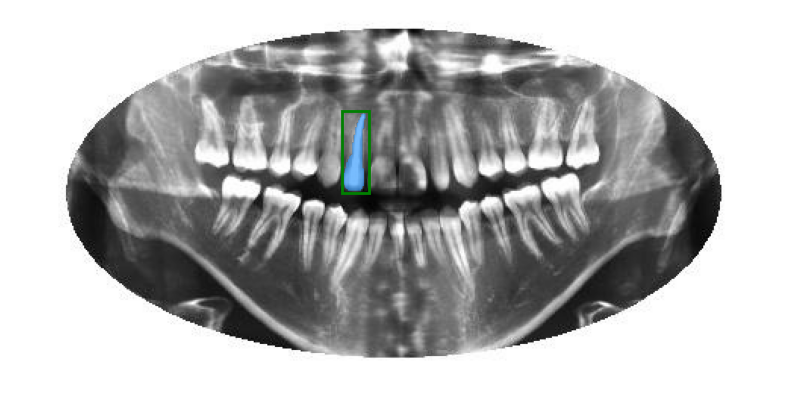

In [ ]:
input_box = np.array(bbox)

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

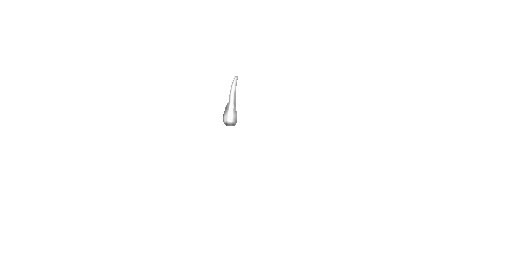

In [ ]:
segmentation_mask = masks[0]
binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

white_background = np.ones_like(image) * 255

new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]

plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()


image 1/1 /content/8_100.jpg: 320x640 1 Implant, 646.9ms
Speed: 5.6ms preprocess, 646.9ms inference, 6.7ms postprocess per image at shape (1, 3, 320, 640)


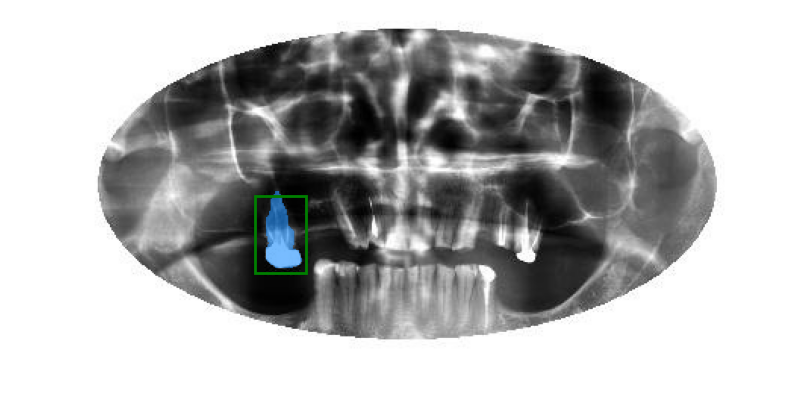

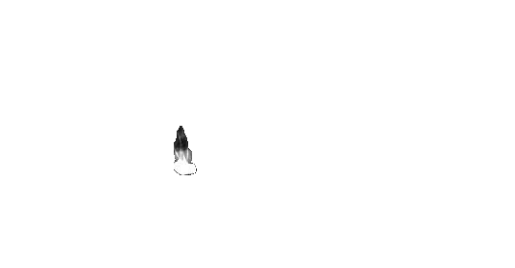

In [ ]:
image_path = '/content/8_100.jpg'

results = model.predict(source=image_path, conf=0.25)

for result in results:
    boxes = result.boxes

bbox=boxes.xyxy.tolist()[0]

image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

predictor.set_image(image)

input_box = np.array(bbox)

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

segmentation_mask = masks[0]
binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

white_background = np.ones_like(image) * 255

new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]

plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()